In [1]:
###########IMPORTS############

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import functional_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import tensor_array_ops

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
###########INTEGRATOR FRAMEWORK############

#1 Constraint Checks

def _check_input_types(t, y0): # Ensure input is Correct
    if not (y0.dtype.is_floating or y0.dtype.is_complex):
        raise TypeError('`y0` must have a floating point or complex floating point dtype')
    if not t.dtype.is_floating:
        raise TypeError('`t` must have a floating point dtype')
        
def _assert_increasing(t): # Check Time is Monotonous
    assert_increasing = control_flow_ops.Assert(math_ops.reduce_all(t[1:] > t[:-1]), ['`t` must be monotonic increasing'])
    return ops.control_dependencies([assert_increasing])

#2 Integrator Class

class _Integrator():
    
    def integrate(self, evol_func, y0, time_grid): # iterator
        time_delta_grid = time_grid[1:] - time_grid[:-1]
        scan_func = self._make_scan_func(evol_func)
        y_grid = functional_ops.scan(scan_func, (time_grid[:-1], time_delta_grid),y0)
        return array_ops.concat([[y0], y_grid], axis=0)
    
    def _make_scan_func(self, evol_func): # stepper function
        
        def scan_func(y, t_dt): 
            if n_>0:
                t,dt = t_dt
                
                dy = self._step_func(evol_func, t, dt, y)
                dy = math_ops.cast(dy, dtype=y.dtype)
                out = y + dy
                
                ## Operate on non-integral
                
                ft = y[-n_:]
                
                l = tf.zeros(tf.shape(ft),dtype=ft.dtype)
                l_ = t-ft
                
                z = tf.less(y[:n_],F_b)
                z_ = tf.greater_equal(out[:n_],F_b)
                
                df = tf.where(tf.logical_and(z,z_),l_,l)
                
                ft_ = ft+df
                
                return tf.concat([out[:-n_],ft_],0)

            else:
                t, dt = t_dt
                dy = self._step_func(evol_func, t, dt, y)
                dy = math_ops.cast(dy, dtype=y.dtype)
                return y + dy
        
        return scan_func

    def _step_func(self, evol_func, t, dt, y):
        k1 = evol_func(y, t)
        half_step = t + dt / 2
        dt_cast = math_ops.cast(dt, y.dtype)

        k2 = evol_func(y + dt_cast * k1 / 2, half_step)
        k3 = evol_func(y + dt_cast * k2 / 2, half_step)
        k4 = evol_func(y + dt_cast * k3, t + dt)
        return math_ops.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)

#3 Integral Caller

def odeint_fixed(func, y0, t):
    t = ops.convert_to_tensor(t, preferred_dtype=dtypes.float64, name='t')
    y0 = ops.convert_to_tensor(y0, name='y0')
    _check_input_types(t, y0)

    with _assert_increasing(t):
        return _Integrator().integrate(func, y0, t)

In [207]:
T = 26                               # Temperature

n_n = 8                              # number of neurons

p_n = 6                              # number of PNs
l_n = 2                              # number of LNs

t = np.arange(0.0, 1200, 0.01)        # duration of simulation

C_m  = [1.0]*n_n                     # Capacitance

# Common Current Parameters #

g_K  = [10.0]*n_n                    # K conductance
g_L  = [0.15]*n_n                    # Leak conductance
g_KL  = [0.05]*p_n + [0.02]*l_n      # K leak conductance

E_K  = [-95.0]*n_n                   # K Potential
E_L  = [-55.0]*p_n + [-50.0]*l_n     # Leak Potential
E_KL  = [-95.0]*n_n                  # K Leak Potential

# Type Specific Current Parameters #

## PNs

g_Na = [100.0]*p_n                   # Na conductance
g_A  = [10.0]*p_n                    # Transient K conductance

E_Na = [50.0]*p_n                    # Na Potential
E_A  = [-95.0]*p_n                   # Transient K Potential

## LNs

g_Ca = [3.0]*l_n                     # Ca conductance
g_KCa = [0.3]*l_n                    # Ca dependent K conductance

E_Ca = [140.0]*l_n                   # Ca Potential
E_KCa = [-90]*l_n                    # Ca dependent K Potential

A_Ca = 2*(10**(-4))
Ca0 = 2.4*(10**(-4))
t_Ca = 150

# Synaptic Current Parameters #

## Acetylcholine

"""ach_mat = np.array([[0.0,0.0,0.0,0.0],
                    [1.0,0.0,0.0,0.0],
                    [1.0,0.0,0.0,0.0],
                    [1.0,0.0,0.0,0.0]])"""

"""ach_mat = np.array([[0.0,0.0],
                    [1.0,0.0]])"""

ach_mat = np.array([[0.,0.,1.,0.,0.,0.,0.,0.],
                    [1.,0.,1.,0.,0.,0.,0.,0.],
                    [0.,0.,0.,0.,0.,1.,0.,0.],
                    [1.,0.,0.,0.,1.,1.,0.,0.],
                    [0.,0.,1.,0.,0.,0.,0.,0.],
                    [0.,1.,0.,0.,1.,0.,0.,0.],
                    [0.,1.,0.,1.,0.,0.,0.,0.],
                    [0.,1.,0.,1.,1.,0.,0.,0.]])

n_syn_ach = int(np.sum(ach_mat))     # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_syn_ach           # Alpha for Ach Synapse
bet_ach = [0.2]*n_syn_ach            # Beta for Ach Synapse
t_max = 0.3                          # Maximum Time for Synapse
t_delay = 0                          # Axonal Transmission Delay
A = [0.5]*n_n                        # Synaptic Response Strength
g_ach = [0.35]*p_n+[0.3]*l_n         # Ach Conductance
E_ach = [0.0]*n_n                    # Ach Potential

## GABAa (fast GABA)

"""fgaba_mat = np.array([[0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,0.0],
                      [0.0,0.0,0.0,1.0],
                      [0.0,0.0,1.0,0.0]])"""

"""fgaba_mat = np.array([[0.0,1.0],
                    [0.0,0.0]])"""

fgaba_mat = np.array([[0.,0.,0.,0.,0.,0.,1.,0.],
                      [0.,0.,0.,0.,0.,0.,1.,0.],
                      [0.,0.,0.,0.,0.,0.,1.,0.],
                      [0.,0.,0.,0.,0.,0.,0.,1.],
                      [0.,0.,0.,0.,0.,0.,0.,1.],
                      [0.,0.,0.,0.,0.,0.,0.,1.],
                      [0.,0.,0.,0.,0.,0.,0.,1.],
                      [0.,0.,0.,0.,0.,0.,1.,0.]])

n_syn_fgaba = int(np.sum(fgaba_mat)) # Number of Fast GABA (fGABA) Synapses
alp_fgaba = [10.0]*n_syn_fgaba       # Alpha for fGABA Synapse
bet_fgaba = [0.16]*n_syn_fgaba       # Beta for fGABA Synapse
V0 = [-20.0]*n_n                     # Decay Potential
sigma = [1.5]*n_n                    # Decay Time Constant
g_fgaba = [0.8]*p_n+[0.8]*l_n        # fGABA Conductance
E_fgaba = [-70.0]*n_n                # fGABA Potential


# Other Parameters #

F_b = [0.0]*n_n                      # Fire potential

inp = [20.0,200.0,400.0,20.0]                 # External Current Inputs

phi = 3.0**((22-T)/10)               # Temp Dependence Parameter


# Property Dynamics #


def K_prop(V):
    
    T = 22
    
    phi = 3.0**((T-36.0)/10)
    
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_inf = alpha_n/(alpha_n+beta_n)
    
    return n_inf, t_n


def Na_prop(V):
    T = 22
    
    phi = 3.0**((T-36)/10)
    
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_inf = alpha_m/(alpha_m+beta_m)
    h_inf = alpha_h/(alpha_h+beta_h)
    
    return m_inf, t_m, h_inf, t_h


def A_prop(V):
    T = 36
    
    phi = 3.0**((T-23.5)/10)
    
    m_inf = 1/(1+tf.exp(-(V+60.0)/8.5))
    h_inf = 1/(1+tf.exp((V+78.0)/6.0))
    
    tau_m = 1/(tf.exp((V+35.82)/19.69) + tf.exp(-(V+79.69)/12.7) + 0.37) / phi
    
    t1 = 1/(tf.exp((V+46.05)/5.0) + tf.exp(-(V+238.4)/37.45)) / phi
    t2 = (19.0/phi) * tf.ones(tf.shape(V),dtype=V.dtype)
    tau_h = tf.where(tf.less(V,-63.0),t1,t2)
    
    return m_inf, tau_m, h_inf, tau_h


def Ca_prop(V):
    
    m_inf = 1/(1+tf.exp(-(V+20.0)/6.5))
    h_inf = 1/(1+tf.exp((V+25.0)/12))
    
    tau_m = 1.5#0.3*tf.exp((V-30.0)/13.0) + 0.002*tf.exp((70.0-V)/29)#1.5#1 + tf.exp((V +30)*0.014) #1.5 
    tau_h = 0.3*tf.exp((V-40.0)/13.0) + 0.002*tf.exp((60.0-V)/29)
    
    return m_inf, tau_m, h_inf, tau_h

def KCa_prop(Ca):
    
    phi = 2.3**((T-23.0)/10)
    
    alpha = 0.01*Ca
    beta = 0.02
    
    tau = 1/((alpha+beta)*phi)
    
    return alpha*tau*phi, tau


# NEURONAL CURRENTS

# Common Currents #

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

def I_KL(V):
    return g_KL * (V - E_KL)

# PN Currents #

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_A(V, m, h):
    return g_A * m**4 * h * (V - E_A)

# LN Currents #

def I_Ca(V, m, h):
    return g_Ca * m**2 * h * (V - E_Ca)

def I_KCa(V, m):
    phi = 2.3**((T-23.0)/10)
    return g_KCa * m * phi * (V - E_KCa)

# SYNAPTIC CURRENTS

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(g_ach*tf.transpose(o_*(V-E_ach)),1)

def I_fgaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),fgaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(g_fgaba*tf.transpose(o_*(V-E_fgaba)),1)


def I_inj_t(t):
    return tf.constant(current_input.T,dtype=tf.float64)[tf.to_int32(t*100)]


In [208]:
def dAdt(X, t):
    
    # Assign Current Values
    
    V_p   = X[0   : p_n] 
    V_l   = X[p_n : n_n]
    
    n_K   = X[n_n : 2*n_n]
    
    m_Na  = X[2*n_n : 2*n_n + p_n]
    h_Na  = X[2*n_n + p_n : 2*n_n + 2*p_n]

    m_A   = X[2*n_n + 2*p_n : 2*n_n + 3*p_n]
    h_A   = X[2*n_n + 3*p_n : 2*n_n + 4*p_n]
    
    m_Ca  = X[2*n_n + 4*p_n : 2*n_n + 4*p_n + l_n]
    h_Ca  = X[2*n_n + 4*p_n + l_n: 2*n_n + 4*p_n + 2*l_n]
    
    m_KCa = X[2*n_n + 4*p_n + 2*l_n : 2*n_n + 4*p_n + 3*l_n]
    Ca    = X[2*n_n + 4*p_n + 3*l_n: 2*n_n + 4*p_n + 4*l_n]

    o_ach = X[6*n_n : 6*n_n + n_syn_ach]
    o_fgaba = X[6*n_n + n_syn_ach : 6*n_n + n_syn_ach + n_syn_fgaba]
    
    fire_t = X[-n_n:]
    
    V = X[:n_n]
    
    
    # Evaluate Differentials
    
    n0,tn = K_prop(V)
    
    dn_k = - (1.0/tn)*(n_K-n0)
    
    m0,tm,h0,th = Na_prop(V_p)
    
    dm_Na = - (1.0/tm)*(m_Na-m0)
    dh_Na = - (1.0/th)*(h_Na-h0)
    
    m0,tm,h0,th = A_prop(V_p)
    
    dm_A = - (1.0/tm)*(m_A-m0)
    dh_A = - (1.0/th)*(h_A-h0)
    
    m0,tm,h0,th = Ca_prop(V_l)
    
    dm_Ca = - (1.0/tm)*(m_Ca-m0)
    dh_Ca = - (1.0/th)*(h_Ca-h0)
    
    m0,tm = KCa_prop(Ca)
    
    dm_KCa = - (1.0/tm)*(m_KCa-m0)
    
    dCa = - A_Ca*I_Ca(V_l,m_Ca,h_Ca) - (Ca - Ca0)/t_Ca
    
    CmdV_p = - I_Na(V_p, m_Na, h_Na) - I_A(V_p, m_A, h_A)
    CmdV_l = - I_Ca(V_l, m_Ca, h_Ca) - I_KCa(V_l, m_KCa)
    
    CmdV = tf.concat([CmdV_p,CmdV_l],0)
    
    dV = (I_inj_t(t) + CmdV - I_K(V, n_K) - I_L(V) - I_KL(V) - I_ach(o_ach,V) - I_fgaba(o_fgaba,V)) / C_m
    
    A_ = tf.constant(A,dtype=tf.float64)
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,tf.zeros(tf.shape(A_),dtype=A_.dtype))
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    T_fgaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_fgaba = tf.multiply(tf.constant(fgaba_mat,dtype=tf.float64),T_fgaba)
    T_fgaba = tf.boolean_mask(tf.reshape(T_fgaba,(-1,)),fgaba_mat.reshape(-1) == 1)
    do_fgabadt = alp_fgaba*(1.0-o_fgaba)*T_fgaba - bet_fgaba*o_fgaba
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype)

    out = tf.concat([dV,         dn_k,
                     dm_Na,      dh_Na,
                     dm_A,       dh_A,
                     dm_Ca,      dh_Ca,
                     dm_KCa,     
                     dCa,        do_achdt,
                     do_fgabadt, dfdt   ],0)
    return out

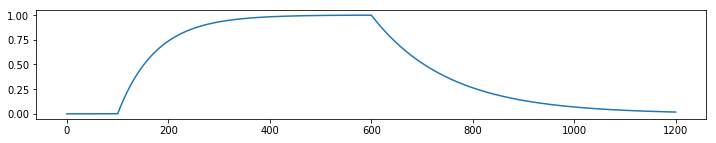

In [209]:
y = np.where(t<600,(1-np.exp(-(t-100)/75)),0.9996*np.exp(-(t-600)/150))
y = np.where(t<100,np.zeros(t.shape),y)
# y = y+0.005*y*np.random.normal(size=t.shape)
plt.figure(figsize=(12,2))
plt.plot(t,y)

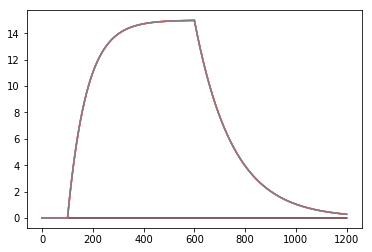

In [280]:
%matplotlib inline
current_input = np.zeros((n_n,t.shape[0]))

fac = 15

current_input[1,:] = fac*y
current_input[3,:] = fac*y
current_input[6,:] = fac*y
current_input[7,:] = fac*y


plt.plot(t,current_input.T)
plt.show()

In [281]:
global n_

n_ = n_n

state_vector =  [-70]* n_n + [0.0]* n_n + [0.0]* (4*p_n) + [0.0]* (3*l_n) + [2.4*(10**(-4))]*l_n + [0]*(n_syn_ach) + [0]*(n_syn_fgaba) + [-500]*n_n
state_vector = np.array(state_vector)
state_vector = state_vector + 0.01*state_vector*np.random.normal(size=state_vector.shape)
init_state = tf.constant(state_vector, dtype=tf.float64)
tensor_state = odeint_fixed(dAdt, init_state, t)

In [282]:
%%time
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state = sess.run(tensor_state)

CPU times: user 26min 57s, sys: 7min 39s, total: 34min 36s
Wall time: 8min 47s


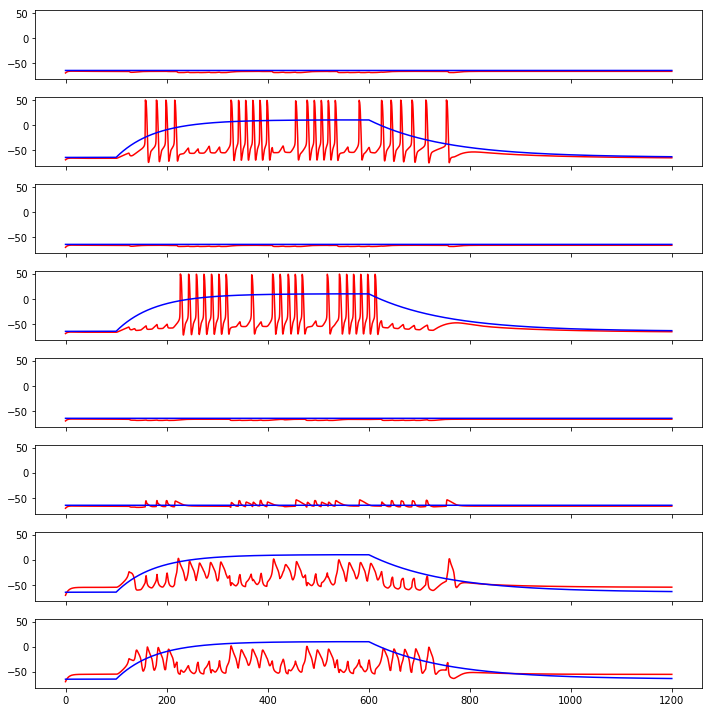

In [283]:
%matplotlib inline
fig, ax = plt.subplots(8, 1,figsize=(10,10),sharex=True,sharey=True)
for n,i in enumerate(ax):
    i.plot(t[:],state[:,n],'r',t[:],(5*current_input[n,:]-65),'b')
    
plt.tight_layout()
plt.show()

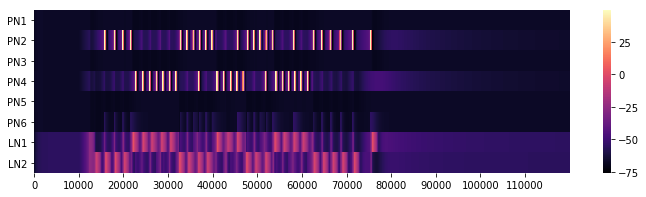

In [284]:
import seaborn as sns
plt.figure(figsize=(12,3))
sns.heatmap(state[:,:8].T,cmap="magma",xticklabels=10000,yticklabels=["PN"+str(i+1) for i in range(p_n)]+["LN"+str(i+1) for i in range(l_n)])
plt.yticks(rotation=0) 
plt.show()